## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [9]:
def baseline(df):
    '''
    50% Yes and No assigned for comparison with implementation
    '''
    output_values = ['Yes', 'No']
    output = []
    for i in range(len(df)):
        rand = np.random.randint(0,2)
        output.append(output_values[rand])

    return np.asarray(output)

test_results(baseline)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0097.

Your nir with this strategy is -569.30.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.0096542738385560836, -569.29999999999995)

In [10]:
#check null values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [12]:
#explore data
features = train_data[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']]
features.describe()

,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


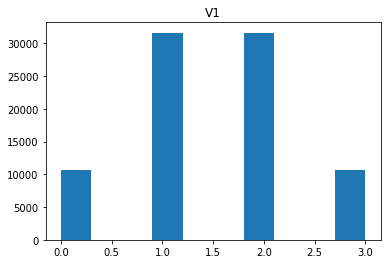

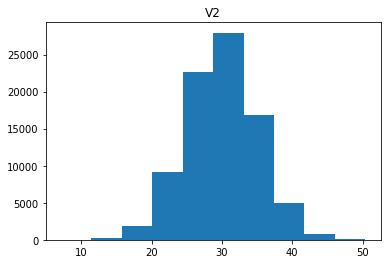

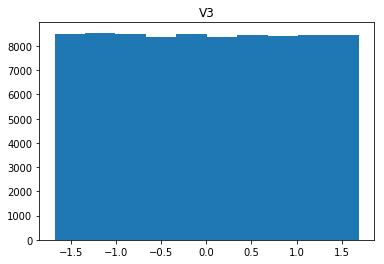

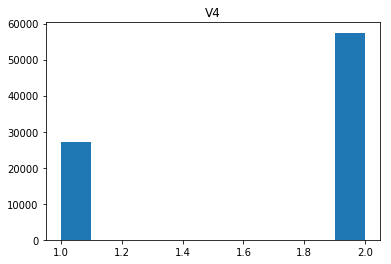

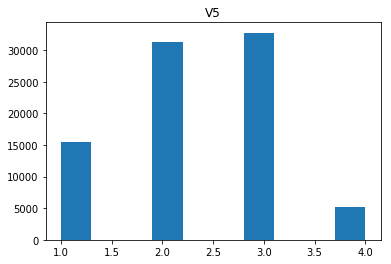

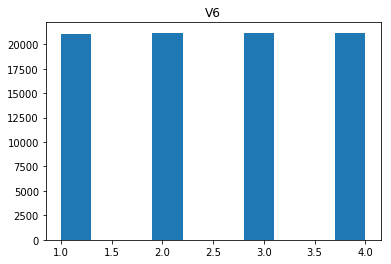

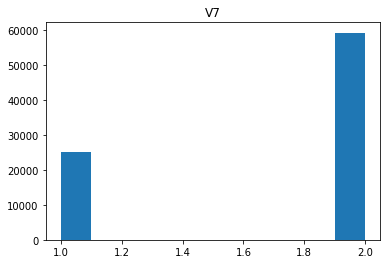

In [14]:
#Plot distributions of all features
for f in features.columns:
    plt.hist(features[f])
    plt.title('{}'. format(f))
    plt.show()

In [15]:
#Convert categoricals to dummy numerics
dummies = pd.get_dummies(train_data, columns = ['V1', 'V4', 'V5', 'V6', 'V7'])
dummies.columns

Index(['ID', 'Promotion', 'purchase', 'V2', 'V3', 'V1_0', 'V1_1', 'V1_2',
       'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 'V6_2',
       'V6_3', 'V6_4', 'V7_1', 'V7_2'],
      dtype='object')

In [16]:
dummies.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [19]:
#Test to check statistical significance of control and experiment groups from a 50-50 split
def promo_test_50split(df, feature):
    treat = df[df.Promotion == 'Yes'][feature]
    cont = df[df.Promotion == 'No'][feature]
    n_total = len(treat) + len(cont)
    p =0.5
    mu = p * n_total
    sd = np.sqrt(p*(1-p)*n_total)
    n_cont = len(cont)
    z = ((n_cont + 0.5) - n_total*p)/np.sqrt(n_total*p*(1-p))
    p_value = 2*sp.stats.norm.cdf(z)
    print("...\nmean = {} \nstd = {} \nz-score = {} \np-value = {}".format(mu,sd,z,p_value))
    if p_value >=0.05:
        print("Fail to Reject. Balanced")
    else:
        print("Not a reasonable split")

promo_test_50split(dummies, 'Promotion')

...
mean = 42267.0 
std = 145.3736564856233 
z-score = -0.6638066506192843 
p-value = 0.5068140685419046
Fail to Reject. Balanced


In [21]:
list_of_features = ['V1_0', 'V1_1', 'V1_2', 'V1_3', 'V4_1', 'V4_2',
                    'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 'V6_2',
                    'V6_3', 'V6_4', 'V7_1', 'V7_2']

for f in list_of_features:
    df = dummies[dummies[f] == 1]
    promo_test_50split(df, f)

...
mean = 5312.5 
std = 51.53882032022076 
z-score = 0.5820855000871992 
p-value = 1.4394909085614855
Fail to Reject. Balanced
...
mean = 15815.5 
std = 88.92553064221771 
z-score = 0.2698887465351364 
p-value = 1.212754155003
Fail to Reject. Balanced
...
mean = 15804.0 
std = 88.89319434017432 
z-score = -1.0743229637416665 
p-value = 0.28267795627902925
Fail to Reject. Balanced
...
mean = 5335.0 
std = 51.647846034466916 
z-score = -1.035861204440105 
p-value = 0.3002668990500855
Fail to Reject. Balanced
...
mean = 13542.0 
std = 82.28608630868283 
z-score = -0.7109342857861388 
p-value = 0.4771249585482401
Fail to Reject. Balanced
...
mean = 28725.0 
std = 119.84364814206884 
z-score = -0.31290769749887426 
p-value = 0.7543507892863371
Fail to Reject. Balanced
...
mean = 7706.0 
std = 62.07253821135398 
z-score = -1.1357679584480809 
p-value = 0.25605369028291614
Fail to Reject. Balanced
...
mean = 15598.0 
std = 88.31194709664146 
z-score = 0.10757321418362532 
p-value = 1.0856657

All the categorical features seem to be balanced.

In [37]:
#test if promotion led to increase in purchase within each group
p_null = dummies.purchase.mean()

def exp_sig_test(df, col):
    n_total = len(df)
    n_cont = float(len(df[df.Promotion == 'No']))
    n_exp = float(len(df[df.Promotion == 'Yes']))
    mean_purchases = df.groupby('Promotion').mean()['purchase']
    
    se_p = np.sqrt(p_null*(1-p_null)*(1/n_cont + 1/n_exp))
    
    z = (mean_purchases[1] - mean_purchases[0])/se_p
    
    p_val = 1- sp.stats.norm.cdf(z)
    print('Feature: {} \np-value: {}'.format(col, p_val))
    if p_val >= 0.05:
        print("\n Promotion not significant enough")

In [38]:
#IIR and NIR for each group
def IIR(p_treat, p_cont, num_treat, num_cont):
    print('IIR: {}'.format((p_treat/num_treat) - (p_cont/num_cont)))

def NIR(p_treat, num_treat, p_cont):
    print('NIR: {}'.format((10*p_treat - 0.15*num_treat) - 10*p_cont))

In [41]:
for col in list_of_features:
    df1= dummies[dummies[col] == 1]
    exp_sig_test(df1, col)
    p_treat = df1[df1.Promotion == 'Yes'].sum()['purchase']
    print('Treatment group purchases: {}'.format(p_treat))
    p_cont = df1[df1.Promotion == 'No'].sum()['purchase']
    print('Control group purchases: {}'.format(p_cont))
    num_treat = len(df1[df1.Promotion == 'Yes'])
    num_cont = len(df1[df1.Promotion == 'No'])
    IIR(p_treat, p_cont, num_treat, num_cont)
    NIR(p_treat, num_treat, p_cont)
    print("\n")

Feature: V1_0 
p-value: 1.1580656755771912e-07
Treatment group purchases: 98
Control group purchases: 40
IIR: 0.011062233977679515
NIR: -212.44999999999993


Feature: V1_1 
p-value: 2.5423759764109377e-09
Treatment group purchases: 252
Control group purchases: 138
IIR: 0.007244775554012248
NIR: -1228.7999999999997


Feature: V1_2 
p-value: 0.0
Treatment group purchases: 302
Control group purchases: 103
IIR: 0.012436542369949698
NIR: -395.0


Feature: V1_3 
p-value: 0.00430059367142277
Treatment group purchases: 69
Control group purchases: 38
IIR: 0.005608252821598726
NIR: -498.35


Feature: V4_1 
p-value: 0.5838376467524564

 Promotion not significant enough
Treatment group purchases: 95
Control group purchases: 98
IIR: -0.0002836315436208197
NIR: -2070.1499999999996


Feature: V4_2 
p-value: 0.0
Treatment group purchases: 626
Control group purchases: 221
IIR: 0.01406023392253487
NIR: -264.4499999999998


Feature: V5_1 
p-value: 2.5202062658991053e-14
Treatment group purchases: 158
Con

Failed to reject promotion V4_2. 
Probably need to look into interactions between groups rather than looking at individual promotions.

Based on the results, 
Assigning "yes" to V1: 0,2; V4: 2; V5: 1,3

Also going to check population size to check if its large enough for stat-sig. 

In [42]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    promotion_df = []
    size = 1
    for i, row in df.iterrows():
        if row['V1'] == 0 or row['V1'] == 2:
            if row['V4'] == 2:
                if row['V5'] == 1 or row['V5'] == 3:
                    promotion_df.append('Yes')
                    size +=1
                else:
                    promotion_df.append('No')
            else:
                promotion_df.append('No')
        else:
            promotion_df.append('No')
    
    promotion_df = np.asarray(promotion_df)
    
    print("Size of Promotion population: {}".format(size))
    
    return promotion_df

In [43]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Size of Promotion population: 8017
Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0228.

Your nir with this strategy is 298.10.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.022793834704630447, 298.10000000000002)

These IRR and NIR results are significantly higher than Udacity's model.